In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs, seed_target_indices
from scipy.stats import ttest_ind

from resting_state.settings import *
from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import low_qual_chans, freq_bands_eeg

Change plot theme

In [2]:
sns.set_theme()

And define a palette to plot with

In [3]:
palette = {'DRD2-WT': '#49A078', 'DRD2-KO': '#ED7D3A'}
cmap_palette = 'YlOrBr'

Let the user select the needed folders

In [4]:
epoch_folder = select_folder("Select the folder that holds epoch files starting with 'epochs_w_cluster_annotations'")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")


List with channels we're not interested in

In [5]:
excluded_chans = ['EMG_L', 'EMG_R']

## Let's load all needed epochs

In [14]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    subj_id = file.split('_')[-1].split('-')[0]
    if not file.startswith('epochs_w_cluster_annotations') or int(subj_id) in omitted_after_clustering or int(
            subj_id) in omitted_other:
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

## Regular connectivity analysis

Let's first define a function that allows us to compute the connectivity using a provided method/metric

In [7]:
def compute_con(epochs, method, fmin=0, fmax=100):
    # Compute spectral connectivity
    con = spectral_connectivity_epochs(
        epochs, method=method, mode='multitaper', sfreq=epochs.info['sfreq'],
        fmin=fmin, fmax=fmax, faverage=True, verbose='WARNING', gc_n_lags=40)
    return con.get_data(output='dense')

And a function that computes a dataframe holding the connectivity for all the subject's epochs.

In [8]:
def connectivity_df(subject_epoch_objects, subject_ids, method):
    print(f'Computing {method} connectivity for subjects:\n {subject_ids}')
    results_df = pd.DataFrame()

    # per subject, calculate the given measure for all epochs
    for subject_epochs in subject_epoch_objects:
        subject_id = int(subject_epochs.metadata['animal_id'].iloc[0])
        if subject_id not in subject_ids or subject_id in omitted_after_clustering or subject_id in omitted_other:
            print(f'Not computing connectivity measure for subject {subject_id} because of quality')
            continue
            
        genotype = subject_epochs.metadata['genotype'].iloc[0]
        
        # get only resting-state epochs
        annotations = cluster_annotations[int(subject_id)]
        resting_epochs = subject_epochs[subject_epochs.metadata["cluster"] == annotations['rest']]
        resting_epochs = resting_epochs.drop_channels(excluded_chans)
    
        # compute the given connectivity measure for every frequency band
        for band_name, (fmin, fmax) in freq_bands_eeg.items():
            # compute the connectivity using the provided method
            con = compute_con(resting_epochs, method, fmin, fmax)
            
            # loop through every channel combination
            for i in range(con.shape[1]):
                for j in range(i+1, con.shape[0]):
                    if subject_id in low_qual_chans.keys():
                        if resting_epochs.ch_names[i] in low_qual_chans[subject_id] or resting_epochs.ch_names[j] in low_qual_chans[subject_id]:
                            continue
                    # add the data
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'con' : con[j, i, 0],
                        'node1' : resting_epochs.ch_names[i],
                        'node2' : resting_epochs.ch_names[j],
                        'band' : band_name,
                        'subject_id': subject_id,
                        'genotype': genotype,
                        'method': method
                    }, index=[0])], ignore_index=True)
    print(f'Done computing {method} connectivity.')
    return results_df

And also a function that allows us to generate a heatmap of the connectivity per channel combination

In [9]:
def generate_con_heatmap(df, freq_band, cmap, fig_title='', method='', ax=None):
    # subset the data for a given frequency band
    filtered_df = df[df['band'] == freq_band]

    # generate pivot table with mean 'method' values
    pivot_table = filtered_df.pivot_table(index='node1', columns='node2', values='con', aggfunc='mean')

    # make table symmetric by filling missing values
    pivot_table = pivot_table.combine_first(pivot_table.T)

    # set diagonal and upper triangle values to NaN, this way we still plot all data
    for i in range(pivot_table.shape[0]):
        for j in range(i, pivot_table.shape[1]):
            pivot_table.iat[i, j] = np.nan

    fig = sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax, square=True, cbar_kws={'shrink': 0.75})
    fig.set_title(fig_title)

    cbar = fig.collections[0].colorbar
    cbar.set_label(f'Mean {method}', fontsize=12)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

Let's quickly check how this works

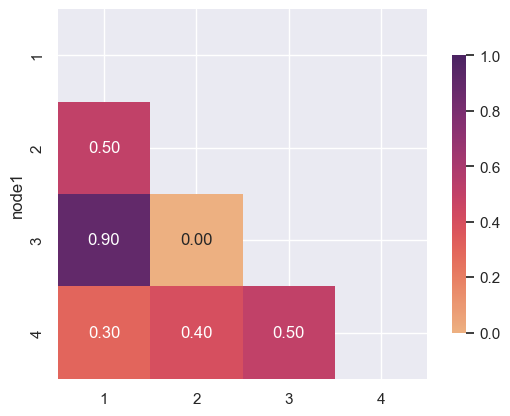

In [11]:
filtered_df = pd.DataFrame({
    'node1': [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
    'node2': [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
    'con':  [.1,.2,.3,.4,.5,.6,.7,.8,.9,.0,.1,.2,.3,.4,.5,.6,]
})

# generate pivot table with mean 'method' values
pivot_table = filtered_df.pivot_table(index='node1', columns='node2', values='con', aggfunc='mean')

# make table symmetric by filling missing values
pivot_table = pivot_table.combine_first(pivot_table.T)

# set diagonal and upper triangle values to NaN, this way we still plot all data
for i in range(pivot_table.shape[0]):
    for j in range(i, pivot_table.shape[1]):
        pivot_table.iat[i, j] = np.nan

fig = sns.heatmap(pivot_table, cmap='flare', annot=True, fmt=".2f", vmin=0, vmax=1, square=True, cbar_kws={'shrink': 0.75})

Now we can see that the reference signal (i, see the dPLI documentation) is on the left.

And a function that allows us to plot the connectivity differences between the two genotypes for the 4 channels of interest

In [12]:
def generate_grid_plot_wt_vs_ko(data):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    method = data['method'].iloc[0]
    freq_band_names = freq_bands_eeg.keys()
    genotypes = data['genotype'].unique()
    
    if method == 'dpli':  # as you interpret dpli differently, change the color palette to a diverging one
        cmap_palette = sns.color_palette('icefire')
        
    # loop through genotypes
    for i, genotype in enumerate(genotypes):
        genotype_data = data[data['genotype'] == genotype]
        for j, band in enumerate(freq_band_names):
            generate_con_heatmap(genotype_data, band, cmap=cmap_palette, fig_title=f'{genotype} - {band} Band', method=method, ax=ax[i, j])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=-0.1)
    save_figure(os.path.join(plot_folder, f"connectivity/{method.upper()}_heatmap.pdf"))

Lastly a function that allows us to generate barplots of the connectivity measures

In [13]:
def generate_barplots(data):
    combinations = data['node1'] + '-' + data['node2']
    unique_combinations = combinations.unique()
    
    fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 18), sharey=True, sharex=True)
    axs = axs.ravel()
    
    method = data['method'].iloc[0]
    
    for i, combination in enumerate(unique_combinations):
        # subset the data
        chan1, chan2 = combination.split('-')
        data_subset = data[(data['node1'] == chan1) & (data['node2'] == chan2)]
        
        sns.barplot(data=data_subset, x="band", y="con", hue="genotype", palette=palette, hue_order=["DRD2-WT", "DRD2-KO"], ax=axs[i], errorbar=None)
        sns.stripplot(data=data_subset, x="band", y="con", hue="genotype", palette='dark:black', hue_order=["DRD2-WT", "DRD2-KO"], alpha=0.4, dodge=True, legend=False, ax=axs[i])
        
        axs[i].set_title(f"Connectivity of {chan1} and {chan2} ({method.upper()})")
        axs[i].set_xlabel("Frequency band")
        axs[i].set_ylabel(f"Connectivity ({method.upper()})")
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    save_figure(os.path.join(plot_folder, f"connectivity/{method.upper()}_bar_grid.pdf"))

### Testing on a single subject (30958)

#### Phase Lag Index exploration

In [13]:
for obj in all_subject_epochs:
    if obj.metadata.animal_id.iloc[0] == '39508':
        epochs_39508 = obj.copy()
        
epochs_39508.drop_channels(['S1_L', 'S1_R', 'V1_R', 'EMG_L', 'EMG_R'])
epochs_39508.info['ch_names']

['OFC_R', 'OFC_L', 'CG', 'STR_R']

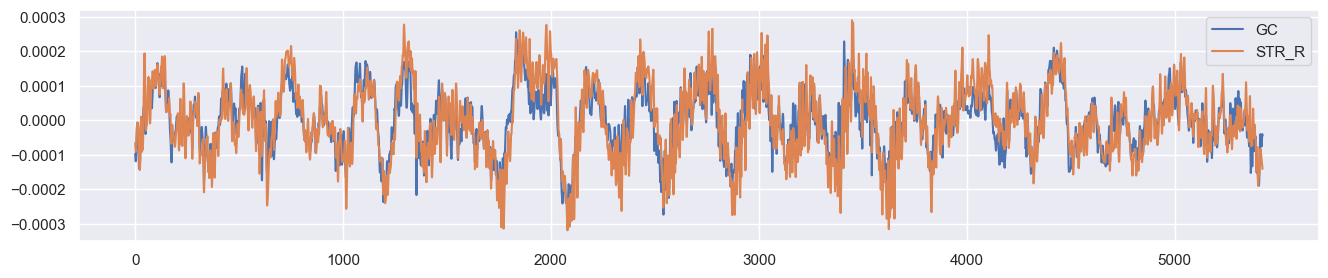

In [14]:
fig = plt.figure(figsize=(16, 3))
plt.plot(epochs_39508[100].get_data(picks='CG')[0,0,:], label='GC')
plt.plot(epochs_39508[100].get_data(picks='STR_R')[0,0,:], label='STR_R')
plt.legend()

Visually, it doesn't seem like one signal is leading or lagging the other.

In [15]:
seeds = [idx for idx, ch_info in enumerate(['OFC_R', 'OFC_L', 'CG', 'STR_R'])]
targets = [idx for idx, ch_info in enumerate(['OFC_R', 'OFC_L', 'CG', 'STR_R'])]
indices = seed_target_indices(seeds, targets)
print(f'Bi-variate indexes used for pairwise connectivity calculations:\n {indices}')

# calculate dpli for one specific epoch
dpli_test = spectral_connectivity_epochs(
    epochs_39508[100], indices=indices, sfreq=epochs_39508.info['sfreq'], method="dpli", fmin=0, fmax=100
)

# report some stuff
print(f'\nShape of the dpli output: {dpli_test.get_data(output="dense").shape}')
print(f'\nLength of the frequency array (holds at which the dPLI is calculated): {len(dpli_test.freqs)}')
print(f'\nThe dPLI output:\n {dpli_test.get_data(output="dense")}')

Bi-variate indexes used for pairwise connectivity calculations:
 (array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]))

Shape of the dpli output: (4, 4, 500)

Length of the frequency array (holds at which the dPLI is calculated): 500

The dPLI output:
 [[[0.5 1.  0.  ... 1.  1.  0. ]
  [0.5 1.  1.  ... 0.  0.  0. ]
  [0.5 1.  1.  ... 0.  0.  0. ]
  [0.5 0.  1.  ... 0.  0.  0. ]]

 [[0.5 0.  0.  ... 1.  1.  1. ]
  [0.5 0.  1.  ... 0.  1.  0. ]
  [0.5 0.  0.  ... 1.  1.  1. ]
  [0.5 0.  0.  ... 1.  1.  1. ]]

 [[0.5 0.  0.  ... 1.  1.  1. ]
  [0.5 1.  1.  ... 0.  0.  0. ]
  [0.5 1.  0.  ... 0.  0.  0. ]
  [0.5 0.  0.  ... 1.  1.  1. ]]

 [[0.5 1.  0.  ... 1.  1.  1. ]
  [0.5 1.  1.  ... 0.  0.  0. ]
  [0.5 1.  1.  ... 0.  0.  0. ]
  [0.5 1.  1.  ... 0.  1.  1. ]]]


C:\Users\Olle de Jong\Documents\MSc Biology\rp2\social-experiments\venv\Lib\site-packages\mne_connectivity\spectral\epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_2008\3843220468.py:7: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 4.999 sec, need at least inf sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  dpli_test = spectral_connectivity_epochs(


Above, we calculated the dpli connectivity measure for one specific epoch. Because we put 'OFC_R', 'OFC_L', 'CG', 'STR_R' in as indices, we get 4x4 = 16 dPLI values per chan to chan comparison. However, we receive a dPLI value per frequency, here resulting in 495 values, which describe the connectivity a different frequencies (see len(dpli_test.freqs))

As we compared the GC and STR_R channels of epoch at index 100 of the resting epochs of 39508, we grab the dPLI values for that specific comparison. Note: this is both from CG to STR_R, but also the other way around. Then we average the dPLI for both.

In [16]:
print(f'Mean dPLI for CG --> STR_R:  {np.average(dpli_test.get_data(output="dense")[2,3,:])}')
print(f'Mean dPLI for STR_R --> CG:  {np.average(dpli_test.get_data(output="dense")[3,2,:])}')

Mean dPLI for CG --> STR_R:  0.681
Mean dPLI for STR_R --> CG:  0.319


We can, from these, observe that they are each others opposites, which makes sense, as we calculate the **directed** phase-lag index here. If one leads or lags the other, the score of the reverse is gonna be the opposite. Note; the dPLI ranges from 0 to 1.

Now, how do we interpret this?

The reference (first provided signal) is lagging the other signal if dPLI is between 0 and 0.5, and the reference signal is leading the other signal is the dPLI is between 0.5 and 1.0.

So, the CG is leading the STR_R signal, or, the STR_R is lagging the CG signal.


#### Granger Causality exploration

In [53]:
# parietal sensors
signals_a = [
    idx
    for idx, ch_info in enumerate(epochs_39508.info["chs"])
    if ch_info["ch_name"] == "STR_R" # TODO can add condition for channel here
]
# occipital sensors
signals_b = [
    idx
    for idx, ch_info in enumerate(epochs_39508.info["chs"])
    if ch_info["ch_name"] == "CG"
]

indices_ab = (np.array([signals_a]), np.array([signals_b]))  # A => B
indices_ba = (np.array([signals_b]), np.array([signals_a]))  # B => A
print(indices_ab)
print(indices_ba)

In [54]:
gc_ab = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc"],
    indices=indices_ab,
    fmin=5,
    fmax=30,
    gc_n_lags=20,
    verbose='WARNING'
)  # A => B
gc_ba = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc"],
    indices=indices_ba,
    fmin=5,
    fmax=30,
    gc_n_lags=20,
    verbose='WARNING'
)  # B => A
freqs = gc_ab.freqs
print(gc_ab.shape)
print(gc_ab)

In [55]:
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc_ab.get_data()[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Granger Causality: [STR_R => CG]")
plt.show()

In [56]:
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc_ba.get_data()[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Granger Causality: [CG => STR_R]")
plt.show()

In [57]:
net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]

fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, net_gc[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Net Granger Causality: [STR_R => CG] - [CG => STR_R]")

By subtracting the flow of information from CG to STR_R from the flow of information of the reverse we get the net granger causality.

This tells us, that for this specific epoch, there's more information flow from the Cingulate Cortex to the Right Striatum than the other way around.

#### Time-traversed Granger Causality

In [58]:
# compute GC on time-reversed signals
gc_tr_ab = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc_tr"],
    indices=indices_ab,
    fmin=5,
    fmax=30,
    gc_n_lags=20,
    verbose='WARNING'
)  # TR[A => B]
gc_tr_ba = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc_tr"],
    indices=indices_ba,
    fmin=5,
    fmax=30,
    gc_n_lags=20,
    verbose='WARNING'
)  # TR[B => A]

# compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()

# compute TRGC
trgc = net_gc - net_gc_tr

Plot the net time-traversed GC

In [59]:
fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, trgc[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("TRGC: net[STR_R => CG] - net time-reversed[CG => STR_R]")

Let's compute the net time-reversed granger causality for the frequencies 0 through 100 Hz.

In [60]:
gc_ab = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc"],
    indices=indices_ab,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
    verbose='WARNING'
)  # A => B
gc_ba = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc"],
    indices=indices_ba,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
    verbose='WARNING'
)  # B => A
freqs = gc_ab.freqs
net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
# compute GC on time-reversed signals
gc_tr_ab = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc_tr"],
    indices=indices_ab,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
    verbose='WARNING'
)  # TR[A => B]
gc_tr_ba = spectral_connectivity_epochs(
    epochs_39508[100],
    method=["gc_tr"],
    indices=indices_ba,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
    verbose='WARNING'
)  # TR[B => A]

# compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()

# compute TRGC
trgc = net_gc - net_gc_tr

fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, trgc[0], linewidth=2)
for band, (start, end) in freq_bands_eeg.items():
    axis.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axis.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axis.text((start + end) / 2, axis.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle(f"TRGC: net[STR_R => CG] - net time-reversed[CG => STR_R]")
plt.show()

### Resting-state, DRD2-KO vs DRD2-WT

As mentioned in the 'rest_psd_analysis.ipynb' notebook, there are a few animals of which the quality is quite poor. We omitted them from the power analysis, so we will do the same here.

In [15]:
wt_ids = [sub_obj.metadata["animal_id"].iloc[0] for sub_obj in all_subject_epochs if sub_obj.metadata["genotype"].iloc[0] == "DRD2-WT"]
ko_ids = [sub_obj.metadata["animal_id"].iloc[0] for sub_obj in all_subject_epochs if sub_obj.metadata["genotype"].iloc[0] == "DRD2-KO"]
print(wt_ids)
print(ko_ids)

['39508', '79602', '80620', '80630', '81207', '81217']
['39489', '78211', '78227', '79592', '79593', '79604', '80625', '81175', '81193', '81218']


We thus remove 81217, 79604, 81193, and 39489.

In [16]:
[wt_ids.remove(x) for x in ['81217', '79604', '81193', '39489'] if x in wt_ids]
[ko_ids.remove(x) for x in ['81217', '79604', '81193', '39489'] if x in ko_ids]
print(wt_ids)
print(ko_ids)

['39508', '79602', '80620', '80630', '81207']
['78211', '78227', '79592', '79593', '80625', '81175', '81218']


In [17]:
passed_subject_ids = wt_ids + ko_ids
passed_subject_ids = [int(x) for x in passed_subject_ids]
passed_subject_ids

[39508,
 79602,
 80620,
 80630,
 81207,
 78211,
 78227,
 79592,
 79593,
 80625,
 81175,
 81218]

### Coherence (coh)

In [89]:
coh = connectivity_df(all_subject_epochs, passed_subject_ids, "coh")
coh.head()

In [110]:
generate_grid_plot_wt_vs_ko(coh)
generate_barplots(coh)

#### Phase Lag Index (PLI)

In [111]:
pli = connectivity_df(all_subject_epochs, passed_subject_ids, "pli")
pli.head()

In [112]:
generate_grid_plot_wt_vs_ko(pli)
generate_barplots(pli)

#### Directed Phase Lag Index (dPLI)

In [18]:
dpli = connectivity_df(all_subject_epochs, passed_subject_ids, "dpli")
dpli.head()

Computing dpli connectivity for subjects:
 [39508, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79593, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 

Not computing connectivity measure for subject 79604 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 

Not computing connectivity measure for subject 81193 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Not computing connectivity measure for subject 81217 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Done computing dpli connectivity.


,con,node1,node2,band,subject_id,genotype,method
0,0.582051,OFC_R,OFC_L,$\delta$,39508,DRD2-WT,dpli
1,0.651282,OFC_R,CG,$\delta$,39508,DRD2-WT,dpli
2,0.202564,OFC_R,STR_R,$\delta$,39508,DRD2-WT,dpli
3,0.705128,OFC_R,S1_L,$\delta$,39508,DRD2-WT,dpli
4,0.615385,OFC_R,S1_R,$\delta$,39508,DRD2-WT,dpli


In [32]:
for combi_data in dpli.groupby(['node1', 'node2']):
    combi, data = combi_data[0], combi_data[1]
    for band in ['$\\delta$', '$\\theta$', '$\\alpha$']:
        band_data = data[data.band == band]
        wt_data, ko_data = band_data[band_data.genotype == 'DRD2-WT'], band_data[band_data.genotype == 'DRD2-KO']
        
        t_stat, p_val = ttest_ind(wt_data.con, ko_data.con)
        if p_val < 0.05:
            print(f'Significant! Combination {combi[0]}-->{combi[1]} has a p-value of {p_val} in band {band}')
        else:
            print(f'Not significant, Combination {combi[0]}-->{combi[1]} has p-value {p_val} in band {band}')

Not significant, Combination CG-->S1_L has p-value 0.5397074461451781 in band $\delta$
Not significant, Combination CG-->S1_L has p-value 0.6810533247768034 in band $\theta$
Not significant, Combination CG-->S1_L has p-value 0.8640070625461769 in band $\alpha$
Not significant, Combination CG-->S1_R has p-value 0.47459282688355275 in band $\delta$
Not significant, Combination CG-->S1_R has p-value 0.4810985328359285 in band $\theta$
Not significant, Combination CG-->S1_R has p-value 0.4353475770349815 in band $\alpha$
Not significant, Combination CG-->STR_R has p-value 0.07571924879600679 in band $\delta$
Not significant, Combination CG-->STR_R has p-value 0.09190906183264355 in band $\theta$
Not significant, Combination CG-->STR_R has p-value 0.17935538165635995 in band $\alpha$
Not significant, Combination CG-->V1_R has p-value 0.31349996361002214 in band $\delta$
Not significant, Combination CG-->V1_R has p-value 0.8969698406979529 in band $\theta$
Not significant, Combination CG-->V

In [57]:
generate_grid_plot_wt_vs_ko(dpli)
generate_barplots(dpli)

When it comes to dPLI. The reference (first provided signal) is lagging the other signal if dPLI is between 0 and 0.5, and the reference signal is leading the other signal is the dPLI is between 0.5 and 1.0.

In the heatmaps we create here, the first provided signal is always on the bottom

#### Weighted Phase Lag Index (wPLI)

In [33]:
wpli = connectivity_df(all_subject_epochs, passed_subject_ids, "wpli")
wpli.head()

Computing wpli connectivity for subjects:
 [39508, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79593, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 

Not computing connectivity measure for subject 79604 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 

Not computing connectivity measure for subject 81193 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Not computing connectivity measure for subject 81217 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Done computing wpli connectivity.


,con,node1,node2,band,subject_id,genotype,method
0,0.346771,OFC_R,OFC_L,$\delta$,39508,DRD2-WT,wpli
1,0.427274,OFC_R,CG,$\delta$,39508,DRD2-WT,wpli
2,0.891064,OFC_R,STR_R,$\delta$,39508,DRD2-WT,wpli
3,0.465942,OFC_R,S1_L,$\delta$,39508,DRD2-WT,wpli
4,0.247446,OFC_R,S1_R,$\delta$,39508,DRD2-WT,wpli


In [34]:
for combi_data in wpli.groupby(['node1', 'node2']):
    combi, data = combi_data[0], combi_data[1]
    for band in ['$\\delta$', '$\\theta$', '$\\alpha$']:
        band_data = data[data.band == band]
        wt_data, ko_data = band_data[band_data.genotype == 'DRD2-WT'], band_data[band_data.genotype == 'DRD2-KO']
        
        t_stat, p_val = ttest_ind(wt_data.con, ko_data.con)
        if p_val < 0.05:
            print(f'Significant! Combination {combi[0]}-->{combi[1]} has a p-value of {p_val} in band {band}')
        else:
            print(f'Not significant, Combination {combi[0]}-->{combi[1]} has p-value {p_val} in band {band}')

Not significant, Combination CG-->S1_L has p-value 0.926635690625883 in band $\delta$
Not significant, Combination CG-->S1_L has p-value 0.991275876804794 in band $\theta$
Not significant, Combination CG-->S1_L has p-value 0.877672831591011 in band $\alpha$
Not significant, Combination CG-->S1_R has p-value 0.14238287224578203 in band $\delta$
Not significant, Combination CG-->S1_R has p-value 0.4266874626801037 in band $\theta$
Not significant, Combination CG-->S1_R has p-value 0.578770093090583 in band $\alpha$
Not significant, Combination CG-->STR_R has p-value 0.31227267013294246 in band $\delta$
Not significant, Combination CG-->STR_R has p-value 0.10346484899900703 in band $\theta$
Not significant, Combination CG-->STR_R has p-value 0.1338343561331454 in band $\alpha$
Significant! Combination CG-->V1_R has a p-value of 0.034356259349587484 in band $\delta$
Not significant, Combination CG-->V1_R has p-value 0.09446355814640733 in band $\theta$
Not significant, Combination CG-->V1_

In [116]:
generate_grid_plot_wt_vs_ko(wpli)
generate_barplots(wpli)

#### Debiased estimator of squared WPLI (wPLI2 debiased)

In [35]:
wpli2 = connectivity_df(all_subject_epochs, passed_subject_ids, "wpli2_debiased")
wpli2.head()

Computing wpli2_debiased connectivity for subjects:
 [39508, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79593, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 

Not computing connectivity measure for subject 79604 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 

Not computing connectivity measure for subject 81193 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Not computing connectivity measure for subject 81217 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Done computing wpli2_debiased connectivity.


,con,node1,node2,band,subject_id,genotype,method
0,0.105801,OFC_R,OFC_L,$\delta$,39508,DRD2-WT,wpli2_debiased
1,0.171709,OFC_R,CG,$\delta$,39508,DRD2-WT,wpli2_debiased
2,0.780848,OFC_R,STR_R,$\delta$,39508,DRD2-WT,wpli2_debiased
3,0.166352,OFC_R,S1_L,$\delta$,39508,DRD2-WT,wpli2_debiased
4,0.032247,OFC_R,S1_R,$\delta$,39508,DRD2-WT,wpli2_debiased


In [36]:
for combi_data in wpli2.groupby(['node1', 'node2']):
    combi, data = combi_data[0], combi_data[1]
    for band in ['$\\delta$', '$\\theta$', '$\\alpha$']:
        band_data = data[data.band == band]
        wt_data, ko_data = band_data[band_data.genotype == 'DRD2-WT'], band_data[band_data.genotype == 'DRD2-KO']
        
        t_stat, p_val = ttest_ind(wt_data.con, ko_data.con)
        if p_val < 0.05:
            print(f'Significant! Combination {combi[0]}-->{combi[1]} has a p-value of {p_val} in band {band}')
        else:
            print(f'Not significant, Combination {combi[0]}-->{combi[1]} has p-value {p_val} in band {band}')

Not significant, Combination CG-->S1_L has p-value 0.989202207280722 in band $\delta$
Not significant, Combination CG-->S1_L has p-value 0.9728347368276832 in band $\theta$
Not significant, Combination CG-->S1_L has p-value 0.8635654772538692 in band $\alpha$
Not significant, Combination CG-->S1_R has p-value 0.12926621576188932 in band $\delta$
Not significant, Combination CG-->S1_R has p-value 0.5037274590679375 in band $\theta$
Not significant, Combination CG-->S1_R has p-value 0.5320826706487202 in band $\alpha$
Not significant, Combination CG-->STR_R has p-value 0.324530581189968 in band $\delta$
Not significant, Combination CG-->STR_R has p-value 0.10907861520299077 in band $\theta$
Not significant, Combination CG-->STR_R has p-value 0.1529759387879988 in band $\alpha$
Significant! Combination CG-->V1_R has a p-value of 0.03400075579102431 in band $\delta$
Not significant, Combination CG-->V1_R has p-value 0.15220402335016683 in band $\theta$
Not significant, Combination CG-->V1_

In [118]:
generate_grid_plot_wt_vs_ko(wpli2)
generate_barplots(wpli2)

#### Pairwise Phase Consistency (PPC)

In [37]:
ppc = connectivity_df(all_subject_epochs, passed_subject_ids, "ppc")
ppc.head()

Computing ppc connectivity for subjects:
 [39508, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79593, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 

Not computing connectivity measure for subject 79604 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(
C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 

Not computing connectivity measure for subject 81193 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Not computing connectivity measure for subject 81217 because of quality


C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_244\398803393.py:3: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


Done computing ppc connectivity.


,con,node1,node2,band,subject_id,genotype,method
0,0.834933,OFC_R,OFC_L,$\delta$,39508,DRD2-WT,ppc
1,0.883217,OFC_R,CG,$\delta$,39508,DRD2-WT,ppc
2,0.906560,OFC_R,STR_R,$\delta$,39508,DRD2-WT,ppc
3,0.514237,OFC_R,S1_L,$\delta$,39508,DRD2-WT,ppc
4,0.513965,OFC_R,S1_R,$\delta$,39508,DRD2-WT,ppc


In [38]:
for combi_data in ppc.groupby(['node1', 'node2']):
    combi, data = combi_data[0], combi_data[1]
    for band in ['$\\delta$', '$\\theta$', '$\\alpha$']:
        band_data = data[data.band == band]
        wt_data, ko_data = band_data[band_data.genotype == 'DRD2-WT'], band_data[band_data.genotype == 'DRD2-KO']
        
        t_stat, p_val = ttest_ind(wt_data.con, ko_data.con)
        if p_val < 0.05:
            print(f'Significant! Combination {combi[0]}-->{combi[1]} has a p-value of {p_val} in band {band}')
        else:
            print(f'Not significant, Combination {combi[0]}-->{combi[1]} has p-value {p_val} in band {band}')

Not significant, Combination CG-->S1_L has p-value 0.2722069259059845 in band $\delta$
Not significant, Combination CG-->S1_L has p-value 0.3549269228583575 in band $\theta$
Not significant, Combination CG-->S1_L has p-value 0.7435144168418546 in band $\alpha$
Not significant, Combination CG-->S1_R has p-value 0.2890751781357318 in band $\delta$
Not significant, Combination CG-->S1_R has p-value 0.816688475187142 in band $\theta$
Not significant, Combination CG-->S1_R has p-value 0.726985712162321 in band $\alpha$
Not significant, Combination CG-->STR_R has p-value 0.11756281504057317 in band $\delta$
Not significant, Combination CG-->STR_R has p-value 0.12977963625902106 in band $\theta$
Not significant, Combination CG-->STR_R has p-value 0.10897676776756518 in band $\alpha$
Not significant, Combination CG-->V1_R has p-value 0.5916079971801464 in band $\delta$
Not significant, Combination CG-->V1_R has p-value 0.3769475228181587 in band $\theta$
Not significant, Combination CG-->V1_R 

In [120]:
generate_grid_plot_wt_vs_ko(ppc)
generate_barplots(ppc)

### Granger Causality between brain-regions; WT vs. KO comparison

First, let's define two functions that allow us to compute the time-reversed Granger Causality between two electrodes.

In [22]:
def compute_indices(subject_epochs, channel_a, channel_b):
    signals_a = [
        idx
        for idx, ch_info in enumerate(subject_epochs.info["chs"])
        if ch_info["ch_name"] == channel_a
    ]
    # occipital sensors
    signals_b = [
        idx
        for idx, ch_info in enumerate(subject_epochs.info["chs"])
        if ch_info["ch_name"] == channel_b
    ]
    
    indices_ab = (np.array([signals_a]), np.array([signals_b]))  # A => B
    indices_ba = (np.array([signals_b]), np.array([signals_a]))  # B => A
    
    return indices_ab, indices_ba

In [25]:
def get_tr_gc(all_subject_epochs, passed_subject_ids, channel_a, channel_b):
    wt_trgcs, ko_trgcs = [], []
    
    for subject_epochs in all_subject_epochs:
        subject_id = subject_epochs.metadata['animal_id'].iloc[0]
        genotype = subject_epochs.metadata['genotype'].iloc[0]
        
        # check if we want to compute for this subject/animal
        if int(subject_id) not in passed_subject_ids:
            print(f'Subject {subject_id} was not picked, skipping..')
            continue
        if int(subject_id) in omitted_after_clustering or int(subject_id) in omitted_other:
            print(f'Skipping {subject_id}..')
            continue
            
        indices_ab, indices_ba = compute_indices(subject_epochs, channel_a, channel_b)
            
        annotations = cluster_annotations[int(subject_id)]
        resting_epochs = subject_epochs[subject_epochs.metadata["cluster"] == annotations['rest']]
        resting_epochs = resting_epochs.drop_channels(excluded_chans)
        
        gc_ab = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc"],
            indices=indices_ab,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # A => B
        gc_ba = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc"],
            indices=indices_ba,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # B => A
        freqs = gc_ab.freqs
        net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
        # compute GC on time-reversed signals
        gc_tr_ab = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc_tr"],
            indices=indices_ab,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # TR[A => B]
        gc_tr_ba = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc_tr"],
            indices=indices_ba,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # TR[B => A]
        
        # compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
        net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()
        
        # compute TRGC
        trgc = net_gc - net_gc_tr
        
        wt_trgcs.append(trgc) if genotype == "DRD2-WT" else ko_trgcs.append(trgc)
        
    return freqs, wt_trgcs, ko_trgcs

#### WT vs KO gridplot of averaged time-reversed Granger Causality

In [41]:
chans = all_subject_epochs[0].info['ch_names']
chans = [chan for chan in chans if chan not in excluded_chans]

fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 18), sharey=True, sharex=True)
axs = axs.ravel()

grid_index = 0
for i in range(len(chans)):
    for j in range(i + 1, len(chans)):
        print(f'Computing combi: {chans[i]} - {chans[j]}')
        freqs, wt_trgcs, ko_trgcs = get_tr_gc(all_subject_epochs, passed_subject_ids, chans[i], chans[j])
        
        averaged_wt_trgcs = np.mean(wt_trgcs, axis=0)
        averaged_ko_trgcs = np.mean(ko_trgcs, axis=0)
        
        axs[grid_index].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
        axs[grid_index].plot(freqs, averaged_wt_trgcs[0], linewidth=2, label='DRD2-WT', color=palette['DRD2-WT'])
        axs[grid_index].plot(freqs, averaged_ko_trgcs[0], linewidth=2, label='DRD2-KO', color=palette['DRD2-KO'])
        axs[grid_index].legend(frameon=False)
        for band, (start, end) in freq_bands_eeg.items():
            axs[grid_index].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[grid_index].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[grid_index].text((start + end) / 2, axs[grid_index].get_ylim()[1], band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        axs[grid_index].set_title(f'{chans[i]}  =>  {chans[j]}', fontsize=15, y=1.02)
        grid_index += 1

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=14)
fig.text(0, 0.5, 'Net Time-reversed Granger Causality', ha='center', va='center', rotation='vertical', fontsize=14)
plt.suptitle('Time-reversed net Granger Causality for all channel combinations (positive value indicates more information flow from first mentioned channel to second mentioned channel)', fontsize=18, fontweight='bold', fontstyle='italic', y=0.99)
plt.tight_layout()
save_figure(os.path.join(plot_folder, f"connectivity/TRGC_wt_vs_ko_grid.pdf"))

There don't seem to bee to big of a differences between KOs and WTs in the above grid.

Let's now dive a bit deeper into the connectivity metrics that seem to differ between certain bands and channels.

### Zoom in on connectivity metrics (dPLI, wPLI & wPLI2-debiased)

#### dPLI

In [126]:
dpli.head()

In [127]:
cg_str = dpli[(dpli.node1 == 'CG') & (dpli.node2 == 'STR_R')]
cg_str

In [128]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), sharex=True)
axs = axs.ravel()

for i, band in enumerate(cg_str.band.unique()):
    wt_data = cg_str[(cg_str.band == band) & (cg_str.genotype == 'DRD2-WT')].con
    ko_data = cg_str[(cg_str.band == band) & (cg_str.genotype == 'DRD2-KO')].con
    
    t_statistic, p_val = ttest_ind(wt_data, ko_data)
    
    sns.boxplot(cg_str[cg_str.band == band], x='genotype', y='con', hue='genotype', palette=palette, ax=axs[i])
    sns.swarmplot(cg_str[cg_str.band == band], x='genotype', y='con', hue='genotype', palette='dark:black', ax=axs[i])
    
    for index, row in cg_str[cg_str.band == band].iterrows():
        axs[i].annotate(row['subject_id'], (row['genotype'], row['con']), textcoords="offset points", xytext=(15,3), ha='center', fontsize=8)
    
    axs[i].set_title(f'Band: {band}')
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    
    y_range = axs[i].get_ylim()
    offset = 0.04 * (y_range[1] - y_range[0])
    
    axs[i].text(0.5, y_range[1] - offset, f'T-stat: {round(t_statistic, 3)}\nP-value: {round(p_val, 3)}', ha='center', va='top', fontsize=9, fontweight='bold')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Directed Phase-lag Index (dPLI)', ha='center', va='center', rotation='vertical', fontsize=12)
# The reference (first provided signal) is lagging the other signal if dPLI is between 0 and 0.5, and the reference signal is leading the other signal is the dPLI is between 0.5 and 1.0.
plt.suptitle('Directed Phase-Lag-Index (dPLI) between the Cingulate Cortex and the Right Striatum.\nA value of 0 through 0.5 indicates that the CG is lagging STR_R more often than it is leading, and 0.5 through 1 indicates the reverse', fontsize=14, fontweight='bold', fontstyle='italic', y=0.99)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f"connectivity/DPLI_CG_STR_boxplot_per_band.pdf"))

#### wPLI

In [129]:
wpli.head()

In [130]:
cg_str = wpli[(wpli.node1 == 'CG') & (wpli.node2 == 'STR_R')]
cg_str

In [131]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), sharex=True)
axs = axs.ravel()

for i, band in enumerate(cg_str.band.unique()):
    wt_data = cg_str[(cg_str.band == band) & (cg_str.genotype == 'DRD2-WT')].con
    ko_data = cg_str[(cg_str.band == band) & (cg_str.genotype == 'DRD2-KO')].con
    
    t_statistic, p_val = ttest_ind(wt_data, ko_data)
    
    sns.boxplot(cg_str[cg_str.band == band], x='genotype', y='con', hue='genotype', palette=palette, ax=axs[i])
    sns.swarmplot(cg_str[cg_str.band == band], x='genotype', y='con', hue='genotype', palette='dark:black', ax=axs[i])
    
    for index, row in cg_str[cg_str.band == band].iterrows():
        axs[i].annotate(row['subject_id'], (row['genotype'], row['con']), textcoords="offset points", xytext=(15,3), ha='center', fontsize=8)

    axs[i].set_title(f'Band: {band}')
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    
    y_range = axs[i].get_ylim()
    offset = 0.04 * (y_range[1] - y_range[0])
    
    axs[i].text(0.5, y_range[1] - offset, f'T-stat: {round(t_statistic, 3)}\nP-value: {round(p_val, 3)}', ha='center', va='top', fontsize=9, fontweight='bold')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Weighted Phase-lag Index (wPLI)', ha='center', va='center', rotation='vertical', fontsize=12)
# The reference (first provided signal) is lagging the other signal if wpli is between 0 and 0.5, and the reference signal is leading the other signal is the wpli is between 0.5 and 1.0.
plt.suptitle('Weighted Phase-Lag-Index (wPLI) between the Cingulate Cortex and the Right Striatum. The higher the value, the more phase synchronization.', fontsize=14, fontweight='bold', fontstyle='italic', y=0.99)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f"connectivity/WPLI_CG_STR_boxplot_per_band.pdf"))

#### wPLI 2, debiased

In [132]:
wpli2.head()

In [133]:
cg_str = wpli2[(wpli2.node1 == 'CG') & (wpli2.node2 == 'STR_R')]
cg_str

In [134]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), sharex=True)
axs = axs.ravel()

for i, band in enumerate(cg_str.band.unique()):
    wt_data = cg_str[(cg_str.band == band) & (cg_str.genotype == 'DRD2-WT')].con
    ko_data = cg_str[(cg_str.band == band) & (cg_str.genotype == 'DRD2-KO')].con
    
    t_statistic, p_val = ttest_ind(wt_data, ko_data)
    
    sns.boxplot(cg_str[cg_str.band == band], x='genotype', y='con', hue='genotype', palette=palette, ax=axs[i])
    sns.swarmplot(cg_str[cg_str.band == band], x='genotype', y='con', hue='genotype', palette='dark:black', ax=axs[i])
    
    for index, row in cg_str[cg_str.band == band].iterrows():
        axs[i].annotate(row['subject_id'], (row['genotype'], row['con']), textcoords="offset points", xytext=(15,3), ha='center', fontsize=8)
        
    axs[i].set_title(f'Band: {band}')
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    
    y_range = axs[i].get_ylim()
    offset = 0.04 * (y_range[1] - y_range[0])
    
    axs[i].text(0.5, y_range[1] - offset, f'T-stat: {round(t_statistic, 3)}\nP-value: {round(p_val, 3)}', ha='center', va='top', fontsize=9, fontweight='bold')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Debiased Weighted Phase-lag Index (wPLI2)', ha='center', va='center', rotation='vertical', fontsize=12)
# The reference (first provided signal) is lagging the other signal if wpli2 is between 0 and 0.5, and the reference signal is leading the other signal is the wpli2 is between 0.5 and 1.0.
plt.suptitle('Debiased Weighted Phase-Lag-Index (wPLI2) between the Cingulate Cortex and the Right Striatum. The higher the value, the more phase synchronization.', fontsize=14, fontweight='bold', fontstyle='italic', y=0.99)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f"connectivity/WPLI2_CG_STR_boxplot_per_band.pdf"))